# Decision Tree Based Model Evaluation on Credit Card Default Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [2]:
# ----------------------------------------------------------------------
# 1. LOAD DATASET
# ----------------------------------------------------------------------
df = pd.read_csv("UCI_Credit_Card.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
# ----------------------------------------------------------------------
# 2. CHECK FOR MISSING VALUES
# ----------------------------------------------------------------------
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


In [4]:
# ----------------------------------------------------------------------
# 3. AUTOMATIC OUTLIER HANDLING (IQR WINSORIZATION)
# ----------------------------------------------------------------------
def winsorize_iqr(dataframe):
    df_out = dataframe.copy()
    numeric_cols = df_out.select_dtypes(include=np.number).columns

    outlier_summary = {}   # store count of outliers per column
    total_outliers = 0

    for col in numeric_cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 2 * IQR
        upper = Q3 + 2 * IQR

        # Count outliers BEFORE clipping
        col_outliers = ((df_out[col] < lower) | (df_out[col] > upper)).sum()
        outlier_summary[col] = int(col_outliers)
        total_outliers += col_outliers

        # Clip values instead of removing rows
        df_out[col] = df_out[col].clip(lower, upper)

    return df_out, outlier_summary, total_outliers

# df, outlier_summary, total_outliers = winsorize_iqr(df)
# print("\nOutliers handled using IQR clipping.")
# print("Outlier summary: ", outlier_summary)
# print("Total outliers: ", total_outliers)

In [5]:
# ----------------------------------------------------------------------
# 4. CATEGORICAL HANDLING (no encoding needed – already numeric)
# ----------------------------------------------------------------------
categorical_cols = ["SEX", "EDUCATION", "MARRIAGE"] + ["PAY_0"] + [f"PAY_{i}" for i in range(2, 7)] + ["default.payment.next.month"]
for col in categorical_cols:
    df[col] = df[col].astype(int)
    df[col] = df[col].astype("category")

df["AGE"] = df["AGE"].astype(int)

In [6]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [7]:
# ----------------------------------------------------------------------
# 5. SPLIT FEATURES & TARGET
# ----------------------------------------------------------------------
X = df.drop(columns=["default.payment.next.month"])
y = df["default.payment.next.month"]

In [8]:
# ----------------------------------------------------------------------
# 6. TRAIN/VAL/TEST SPLIT
# ----------------------------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("\nTrain / Validation / Test shapes:")
print(X_train.shape, X_val.shape, X_test.shape)


Train / Validation / Test shapes:
(21000, 24) (4500, 24) (4500, 24)


In [9]:
# ----------------------------------------------------------------------
# 7. SCALING
# ----------------------------------------------------------------------
scaler = StandardScaler()

num_cols = X_train.select_dtypes(include=np.number).columns

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print("\nScaling complete.")


Scaling complete.


In [10]:
# ----------------------------------------------------------------------
# 8. HYPERPARAMETER TUNING (GRIDSEARCH) FOR ALL MODELS
# ----------------------------------------------------------------------

def evaluate_model(model_name, model, X_val, y_val):
    pred = model.predict(X_val)
    prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
    print(f"\n====== {model_name} VALIDATION METRICS ======")
    print("Accuracy :", accuracy_score(y_val, pred))
    print("Precision:", precision_score(y_val, pred))
    print("Recall   :", recall_score(y_val, pred))
    print("F1-Score :", f1_score(y_val, pred))
    if prob is not None:
        print("ROC-AUC  :", roc_auc_score(y_val, prob))
    print("\nClassification Report:")
    print(classification_report(y_val, pred))

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_val, pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix – {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Best Decision Tree params: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}

====== Decision Tree VALIDATION METRICS ======
Accuracy : 0.8195555555555556
Precision: 0.6742857142857143
Recall   : 0.35577889447236183
F1-Score : 0.46578947368421053
ROC-AUC  : 0.7295236524993011

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3505
           1       0.67      0.36      0.47       995

    accuracy                           0.82      4500
   macro avg       0.76      0.65      0.68      4500
weighted avg       0.80      0.82      0.80      4500



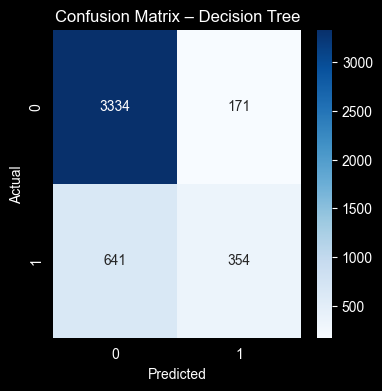

In [11]:
# -------------------- Decision Tree --------------------
dt_params = {
    "max_depth": [4, 6, 8, 10, 12],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=dt_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

dt_grid.fit(X_train_scaled, y_train)
best_dt = dt_grid.best_estimator_
print("\nBest Decision Tree params:", dt_grid.best_params_)
evaluate_model("Decision Tree", best_dt, X_val_scaled, y_val)


Best Random Forest params: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100}

====== Random Forest VALIDATION METRICS ======
Accuracy : 0.8173333333333334
Precision: 0.6660268714011516
Recall   : 0.3487437185929648
F1-Score : 0.4577836411609499
ROC-AUC  : 0.7726785138244718

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3505
           1       0.67      0.35      0.46       995

    accuracy                           0.82      4500
   macro avg       0.75      0.65      0.67      4500
weighted avg       0.80      0.82      0.79      4500



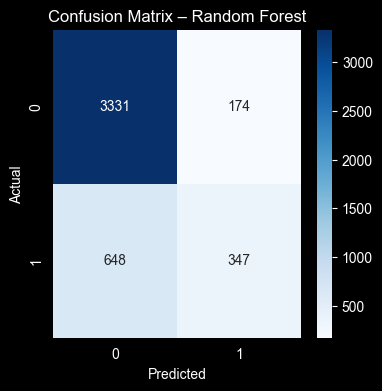

In [14]:
# -------------------- Random Forest --------------------
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [6, 8, 10],
    "min_samples_split": [2, 5],
    "max_features": ["log2", "sqrt"]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_
print("\nBest Random Forest params:", rf_grid.best_params_)
evaluate_model("Random Forest", best_rf, X_val_scaled, y_val)


Best Gradient Boosting params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

====== Gradient Boosting VALIDATION METRICS ======
Accuracy : 0.8204444444444444
Precision: 0.6801541425818882
Recall   : 0.35477386934673366
F1-Score : 0.4663143989431968
ROC-AUC  : 0.7790041505673876

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3505
           1       0.68      0.35      0.47       995

    accuracy                           0.82      4500
   macro avg       0.76      0.65      0.68      4500
weighted avg       0.80      0.82      0.80      4500



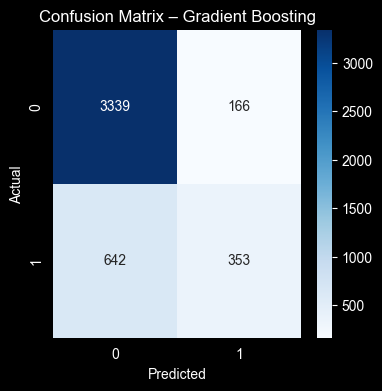

In [13]:
# -------------------- Gradient Boosting --------------------
gb_params = {
    "n_estimators": [100, 150],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3, 4]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=gb_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

gb_grid.fit(X_train_scaled, y_train)
best_gb = gb_grid.best_estimator_
print("\nBest Gradient Boosting params:", gb_grid.best_params_)
evaluate_model("Gradient Boosting", best_gb, X_val_scaled, y_val)